# Jobba med enkätdata
English version | [Startsida](../index.html)


I många av exemplen på den här sajten jobbar vi med landsdata. Många variabler är där naturligt kontinuerliga, till exempel när det gäller makroekonomiska indikatorer som BNP eller arbetslöshet.

När man jobbar med enkätdata ser data lite annorlunda ut. De fleseta frågor har bara ett fåtal svarsalternativ, istället för att vara långa skalor. I många fall saknas värden, när folk låtit bli att svara på hela eller delar av en fråga. Kodningen av svarsalternativen är inte heller alltid helt intuitiv.

I den här guiden kommer vi gå igenom några typiska problem man kan stöta på när man jobbar med enkätdata, och vad man kan göra åt dem:

Problem 1: Missing-koder i datan<br>
Problem 2: Skalor vända åt fel håll<br>
Problem 3: Sambandsanalyser fungerar inte på grund av "no observations" <br>
Problem 4: Scatterplots blir till konstiga rutnät<br>
Problem 5: R2-värdet blir lågt

Datan vi använder är SOM-institutets nationella undersökning från 2016. Den är tyvärr inte fritt tillgänglig, men om man vill använda den i en uppsats eller forskningsrapport kan man beställa den från [Svensk Nationell Datatjänst](https://snd.gu.se/sv).

In [ ]:
use "Riks-SOM 2016-swe.dta", clear

In [10]:
recode f10a (6 96 97 98 99 = .), generate(fortroende_svt)

(132 differences between f10a and fortroende_svt)


Det som hände nu var alltså att vi tog bort värdena 6, 96, 97, 98 och 99. Övriga värden stod kvar. Om vi nu tittar på den nya variabeln ser vi att den nu bara har värdena 1-5, och den kan nu lättare användas i analyser.

In [11]:
tab fortroende_svt


  RECODE of |
f10a (F10a. |
 F�rtroende |
        f�r |
inneh�llet: |
   Sveriges |
Television) |      Freq.     Percent        Cum.
------------+-----------------------------------
          1 |        510       32.69       32.69
          2 |        742       47.56       80.26
          3 |        204       13.08       93.33
          4 |         58        3.72       97.05
          5 |         46        2.95      100.00
------------+-----------------------------------
      Total |      1,560      100.00


## Problem 2: Skalor vända åt fel håll

Ett problem kvarstår dock. Om man kollar på informationen som vi fick med `codebook` tidigare kunde vi se att de som hade "Mycket stort förtroende" på variabeln har värdet 1. De som har "Mycket litet förtroende" har värdet 5. Det känns för mig väldigt krångligt. En ökning på variabeln betyder att förtroende minskar.

Rent statistiskt spelar det ingen roll, men risken för missförstånd och feltolkningar ökar. Jag tycker att det är mycket bättre att höga värden på en variabeln indikerar "mer" och "högt". Vi gör därför en ny variant av "f10a", med hjälp av `recode` där vi också säger att de riktiga värdena ska ändras.

### Lösning: Använd `recode` för att vända på skalan

Vi kopierar koden från ovan, men lägger till fem nya parenteser, där varje gammalt värde får ett nytt. De gamla 1 får värdet 5, de gamla 2 får värdet 4, osv. Det gamla värdet står först i parenteserna.

In [12]:
recode f10a (6 96 97 98 99 = . ) (1=5) (2=4) (3=3) (4=2) (5=1), generate(fortroende_svt_vand)

(1488 differences between f10a and fortroende_svt_vand)


In [13]:
tab fortroende_svt_vand


  RECODE of |
f10a (F10a. |
 F�rtroende |
        f�r |
inneh�llet: |
   Sveriges |
Television) |      Freq.     Percent        Cum.
------------+-----------------------------------
          1 |         46        2.95        2.95
          2 |         58        3.72        6.67
          3 |        204       13.08       19.74
          4 |        742       47.56       67.31
          5 |        510       32.69      100.00
------------+-----------------------------------
      Total |      1,560      100.00


De som har en femma på variabeln är nu de som har högst förtroende. Fem plus. Mycket lättare att förstå, tycker i alla fall jag!

## Problem 3: Sambandsanalyser fungerar inte på grund av "no observations"

Säg nu att vi vill undersöka sambandet mellan förtroende för Svt och hur ofta man uttrycker en åsikt på sociala medier. Det finns en sådan variabel, "f89e":

In [14]:
tab f89e


 F89e. Uttrycka �sikt i |
      samh�llsfr�ga: P� |
internet (t.ex. sociala |
        medier, blogg e |      Freq.     Percent        Cum.
------------------------+-----------------------------------
  Flera g�nger i veckan |         72        4.53        4.53
    N�gon g�ng i veckan |        105        6.60       11.13
   N�gon g�ng i m�naden |        135        8.49       19.61
             Mer s�llan |        344       21.62       41.23
                 Aldrig |        840       52.80       94.03
Ej svar - del av fr�gan |         44        2.77       96.79
  Ej svar � hela fr�gan |         51        3.21      100.00
------------------------+-----------------------------------
                  Total |      1,591      100.00


Nästan 1500 personer har gett giltiga svar på frågan. Här bör man visserligen först koda bort felkoderna "Ej svar" med hjälp av `recode` som ovan, men vi struntar i det just nu. När vi nu tar ut till exempel en [korrelation](correlation_sv.html) mellan fortroende_svt_vand och f89e får vi följande resultat:

In [15]:
pwcorr fortroende_svt_vand f89e

no observations


r(2000);


No observations - ingen data. Hur kan det komma sig? Ca 1500 personer hade ju svarat på SVT-frågan, och ca 1500 på sociala medier-frågan. Problemet är att det inte är samma personer. SOM-institutet skickar ut flera olika versioner av enkäten, och de flesta frågor ställs bara i någon enstaka version, för att inte göra formuläret alldeles för långt.

För att veta om de som har högt förtroende för SVT är mer eller mindre benägna att uttrycka sin åsikt på sociala medier måste just de som svarat på förtroendefrågan också ha svarat på sociala medier-frågan. Om man tittar i kodboken så ser man vanligtvis vilka frågor som ingår vilka versioner av enkäten.

### Lösning: Välj andra variabler

Här finns ingen teknisk lösning. Finns inte datan så finns inte datan. Om det är en stor enkät kan det dock hända att det finns andra variabler som har ställts tillsammans, och som kanske fångar upp liknane saker. Till exempel finns det en variabel som frågar om hur ofta man använder mobilen för att kolla sociala medier. Såklart inte samma sak som att uttrycka sin åsikt, men kanske fångar det ändå upp något.

## Problem 4: Scatterplots blir till konstiga rutnät

Vi vill nu titta på sambandet mellan personens placering på den ideologiska vänster-högerskalan och förtroendet för SVT. Vi gör först en ny variabel för vänster-högerplacering ("f45"), där vi tar bort felkoderna:

In [17]:
recode f45 (96 97 98 99 = .), generate(vhskala)

(354 differences between f45 and vhskala)


Nu gör vi ett [spridningsdiagram](graphs_scatterplot_sv.html), en scatterplot där vi sätter vhskala på x-axeln och förtroende för SVT på y-axeln:

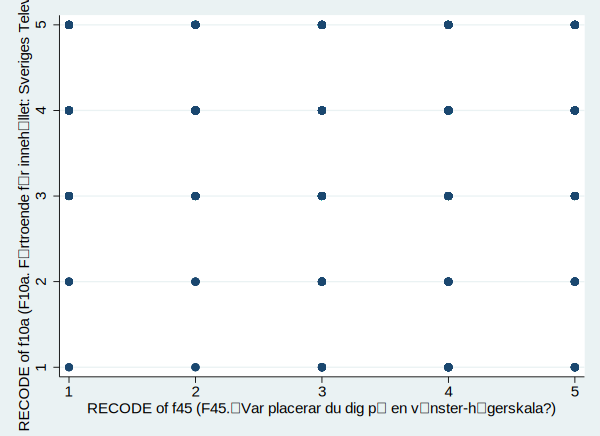

In [18]:
twoway (scatter fortroende_svt_vand vhskala)

Grafen ser väldigt märklig ut, men är logisk. Tänk på att det är enkätfrågor, med ett antal fasta svarsalternativ. Man kan inte svara att man är 2,7 på den ideologiska skalan, eller 3,2 på förtroende-skalan. Eftersom båda variablerna har fem alternativ blir det 25 kombinationer av svar, och det är 25 prickar vi ser i diagrammet. Dock kan det vara flera hundra personer gömda bakom en prick. De är lagrade ovanpå varandra i diagrammet. Men det ser vi inte, vilket gör det väldigt svårt att se om det finns något samband.

### Lösning 1: Använd transperens för att tydligare se hur många som gömmer sig på varje plats i diagrammet

En halvbra lösning är att göra punkterna mestadels genomskinliga. När man då placerar många punkter ovanpå varandra får de en mörkare färg. Vi kommer då tydligare se vart det är många personer i diagrammet Vi gör detta med ett option inne i scatter-parentesen, `mcolor()`. Vi väljer då en färg, och anger med en procentsiffra hur synlig den ska vara.

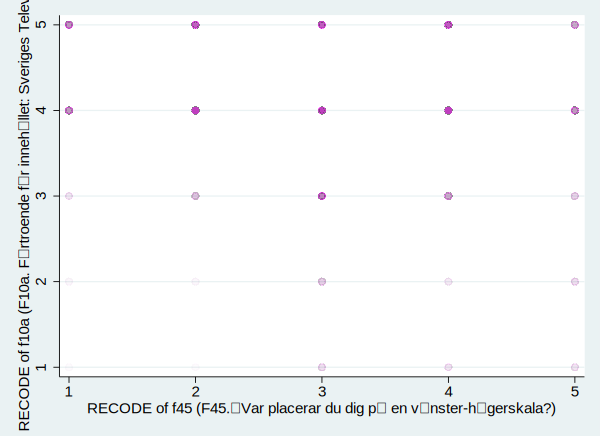

In [19]:
twoway (scatter fortroende_svt_vand vhskala, mcolor(purple%1))

Lite bättre! Vi kan nu se att det i princip inte är någon som står längst till vänster som har riktigt lågt förtroende för SVT. Inte heller på högerkanten är det jättemånga, men något fler, vad det verkar.

### Lösning 2: Gör ett stapeldiagram

Ännu bättre är dock oftast att göra ett [stapeldiagram](barcharts_sv.html) som visar medelvärdet på den beroende variabeln för varje kategori på den oberoende variabeln. Vi gör det med hjälp av kommandot `graph bar`.

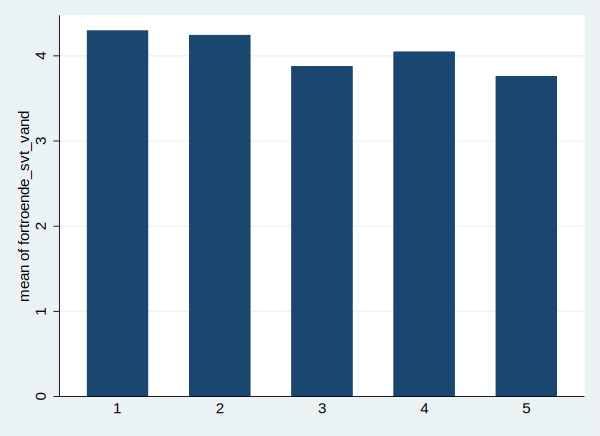

In [20]:
graph bar (mean) fortroende_svt_vand, over(vhskala)

Sambandet är inte jättetydligt. Men vi kan ändå se att värdena är något lägre bland de som har högre värden på vh-skalan, alltså är längre till höger. Vi kan också fixa till diagrammet mer, till exempel genom skriva ut vad de faktiska medelvärdena är. Se [separat guide](barcharts_sv.html) för det.

## Problem 5: R2-värdet blir väldigt lågt

R2-värdet är ett mått i regressionsanalys som visar modellens passning, eller med andra ord, hur bra vi kan gissa värdet på den beroende variabeln, utifrån den oberoende variabelns värde. Ett högt R2-värde (närmare 1) omtalas ibland som "bättre".

När man jobbar med enkätdata kan dock R2-värdet ofta bli väldigt lågt. Om vi till exempel gör en regressionsanalys med förtroende för SVT som beroende variabel och Vänster/höger-skalan som oberoende så märker vi att R2 bara blir 0.0203, alltså 2 procent ungefär!

In [22]:
reg fortroende_svt_vand vhskala


      Source |       SS           df       MS      Number of obs   =     1,539
-------------+----------------------------------   F(1, 1537)      =     31.87
       Model |  27.3547439         1  27.3547439   Prob > F        =    0.0000
    Residual |  1319.27034     1,537  .858341143   R-squared       =    0.0203
-------------+----------------------------------   Adj R-squared   =    0.0197
       Total |  1346.62508     1,538  .875568973   Root MSE        =    .92647

------------------------------------------------------------------------------
fortroende~d |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
     vhskala |  -.1162755   .0205969    -5.65   0.000    -.1566765   -.0758745
       _cons |   4.386951   .0675146    64.98   0.000     4.254521    4.519382
------------------------------------------------------------------------------


### Lösning: Ta det lugnt

Det är dock inget man ska bli särskilt förvånad över. Man måste tänka på att datan utgörs av enkätsvar. Många tänker inte så noga när de svarar på enkäten, och svaren blir därför mer eller mindre slumpmässiga. Sådan slump kan inte förklaras av någon variabel, vilket drar ner R2.

Med enkätdata av den här typen är det därför inte ovanligt att R2 är några få procent, som i det här exemplet. Men det betyder alltså inte att hypotesen är fel, eller att data inte gäller, bara att det är svårt att gissa exakt vad folk känner. R2-värden på 20-30% blir det oftast bara när man samkör variabler som har en närmast trivial koppling, som sambandet mellan förtroende för en partiledare och förtroende för dennes parti.

## Avslutning
Det var några vanliga problem som kan dyka upp när man jobbar med enkätdata. Tänk på att ta det långsamt, och dubbelkolla alla eventuella omkodningar så att det är rätt antal personer i varje kategori.